In [1]:
!pip3 install pyspark

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pyspark import SparkContext

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("local") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext


In [4]:
spark

Once we have our RDD of Row we can infer and register the schema.

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html

In [7]:
DF = spark.read.load("otomoto.csv", format="csv", sep=";", inferSchema="true", header="true")

In [10]:
DF.registerTempTable("cars")

In [18]:
all_cars = sqlContext.sql("""
    Select przebieg from cars
""")

In [19]:
type(all_cars)

pyspark.sql.dataframe.DataFrame

* https://spark.apache.org/docs/latest/api/java/org/apache/spark/sql/functions.html
* https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#module-pyspark.sql.functions
* 

In [34]:
from pyspark.sql.functions import *

In [79]:
CARS = DF.select('id','Marka pojazdu', "Model pojazdu", "przebieg", "price", "rok produkcji")
CARS = CARS.dropna()
CARS = CARS.withColumn("przebieg", regexp_replace(CARS['przebieg'], '\s', ''))
CARS = CARS.withColumn("przebieg", regexp_replace(CARS['przebieg'], 'km', ''))
CARS = CARS.withColumn("przebieg", CARS['przebieg'].cast('int'))


In [81]:
CARS.printSchema()

root
 |-- id: long (nullable = true)
 |-- Marka pojazdu: string (nullable = true)
 |-- Model pojazdu: string (nullable = true)
 |-- przebieg: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- rok produkcji: integer (nullable = true)



In [82]:
from pyspark.sql.functions import udf
udf?

In [83]:
lowercase_name = udf(lambda x: x.lower(), "string")

In [84]:
CARS = CARS.withColumn("Marka pojazdu", lowercase_name(CARS["Marka pojazdu"]))
CARS = CARS.withColumn("Model pojazdu", lowercase_name(CARS["Model pojazdu"]))

In [85]:
CARS = CARS.withColumnRenamed("Marka pojazdu", 'marka') \
    .withColumnRenamed("Model pojazdu", 'model') \
    .withColumnRenamed("rok produkcji", 'rok')

In [86]:
CARS.take(10)

[Row(id=6039269187, marka='renault', model='fluence', przebieg=172000, price=25900.0, rok=2013),
 Row(id=6034090022, marka='mercedes-benz', model='klasa g', przebieg=52904, price=434900.0, rok=2016),
 Row(id=6039268812, marka='audi', model='a5', przebieg=56000, price=41900.0, rok=2011),
 Row(id=6039269107, marka='volkswagen', model='polo', przebieg=88000, price=14900.0, rok=2007),
 Row(id=6038674457, marka='peugeot', model='206 cc', przebieg=176000, price=5900.0, rok=2001),
 Row(id=6033752462, marka='volkswagen', model='bora', przebieg=300000, price=7900.0, rok=2003),
 Row(id=6035637917, marka='bmw', model='seria 5', przebieg=301000, price=9800.0, rok=2002),
 Row(id=6038678372, marka='audi', model='q5', przebieg=155400, price=98900.0, rok=2013),
 Row(id=6039268967, marka='hyundai', model='santa fe', przebieg=124500, price=14480.0, rok=2004),
 Row(id=6039268802, marka='volkswagen', model='golf', przebieg=95100, price=64900.0, rok=2014)]

In [114]:
price_millage = CARS.select("rok", "przebieg").toPandas()

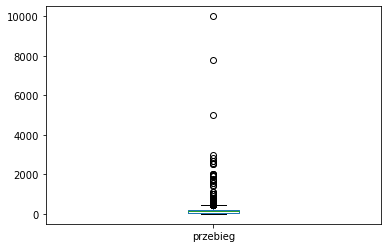

In [117]:
(price_millage['przebieg']/1000).plot.box()

In [123]:
from pyspark.ml.stat import Summarizer

summarizer = Summarizer.metrics("mean", "count")
# compute statistics for multiple metrics without weight


SyntaxError: unexpected EOF while parsing (<ipython-input-123-63582fcc881c>, line 5)

In [90]:
years = CARS.select("rok").toPandas()

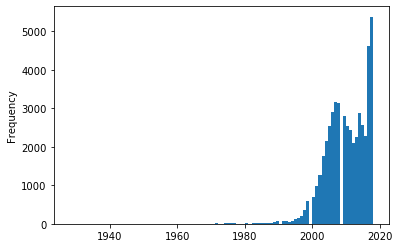

In [93]:
years['rok'].sort_values() \
    .plot(kind='hist', bins = 100)

In [97]:
by_brand = CARS.select("marka").groupBy("marka").count().toPandas()

In [96]:
type(by_brand)

pyspark.sql.dataframe.DataFrame

In [99]:
len(by_brand)

87

In [204]:
CARS.count()

50610

In [103]:
CARS_S = CARS.sample(True, 0.1)

In [104]:
CARS_S.count()

5107

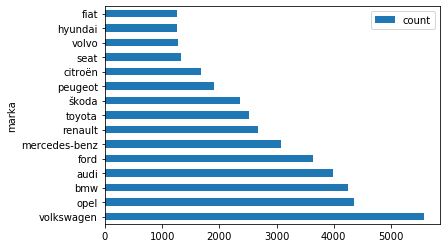

In [113]:
by_brand.index = by_brand['marka']
by_brand.sort_values(by='count', ascending=False)[:15].plot.barh()

In [127]:
przebieg_data

0        172000
1         52904
2         56000
3         88000
4        176000
          ...  
50605    230000
50606    160700
50607    128486
50608         5
50609    139000
Name: przebieg, Length: 50610, dtype: int32

In [185]:
przebieg_data = CARS.select('przebieg').toPandas()

In [186]:
przebieg_data['przebieg'] = przebieg_data['przebieg'] / 1000

In [187]:
przebieg_data.describe()

,przebieg
count,50610.000000
mean,134.374310
std,119.935487
min,0.001000
25%,39.763250
50%,143.000000
75%,200.000000
max,9999.999000


In [188]:
przebieg_data = przebieg_data[przebieg_data['przebieg'] < 500]

In [189]:
przebieg_data

,przebieg
0,172.000
1,52.904
2,56.000
3,88.000
4,176.000
...,...
50605,230.000
50606,160.700
50607,128.486
50608,0.005


In [190]:
przebieg_data['przebieg']

0        172.000
1         52.904
2         56.000
3         88.000
4        176.000
          ...   
50605    230.000
50606    160.700
50607    128.486
50608      0.005
50609    139.000
Name: przebieg, Length: 50541, dtype: float64

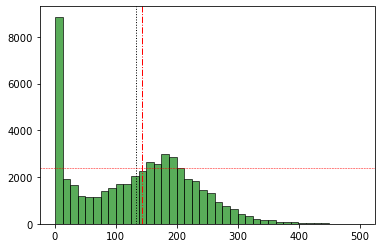

In [191]:
import matplotlib.pyplot as plt
import numpy as np
plt_data = przebieg_data['przebieg']
H, xedges, yedges = plt.hist(plt_data, bins=40, color='green', edgecolor='k', alpha=0.65)

av_line = plt.axvline(plt_data.mean(), color='k', linestyle=':', linewidth=1)
med_line = plt.axvline(plt_data.median(), color='red', linestyle='-.', linewidth=1)
other = plt.axhline(2400, linewidth=.5, color='r', linestyle='--')

# plt.legend([av_line, med_line], ["średnia {}k".format(int(round(plt_data.mean()))), 'mediana'])
# xlabels = map(lambda x: "{}k".format(int(x/1000)) ,np.arange(0, 500000, 50000))
#plt.xticks(np.arange(0, 500000, 50000), xlabels)

plt.show()

In [210]:
top_marki = CARS.select("marka").groupBy("marka").count()\
    .sort("count", ascending=False)\
    .limit(10) \
    .collect()

In [212]:
top_marki = [row.marka for row in top_marki]

In [213]:
top_marki

['volkswagen',
 'opel',
 'bmw',
 'audi',
 'ford',
 'mercedes-benz',
 'renault',
 'toyota',
 'škoda',
 'peugeot']

AttributeError: 'NoneType' object has no attribute '_jvm'

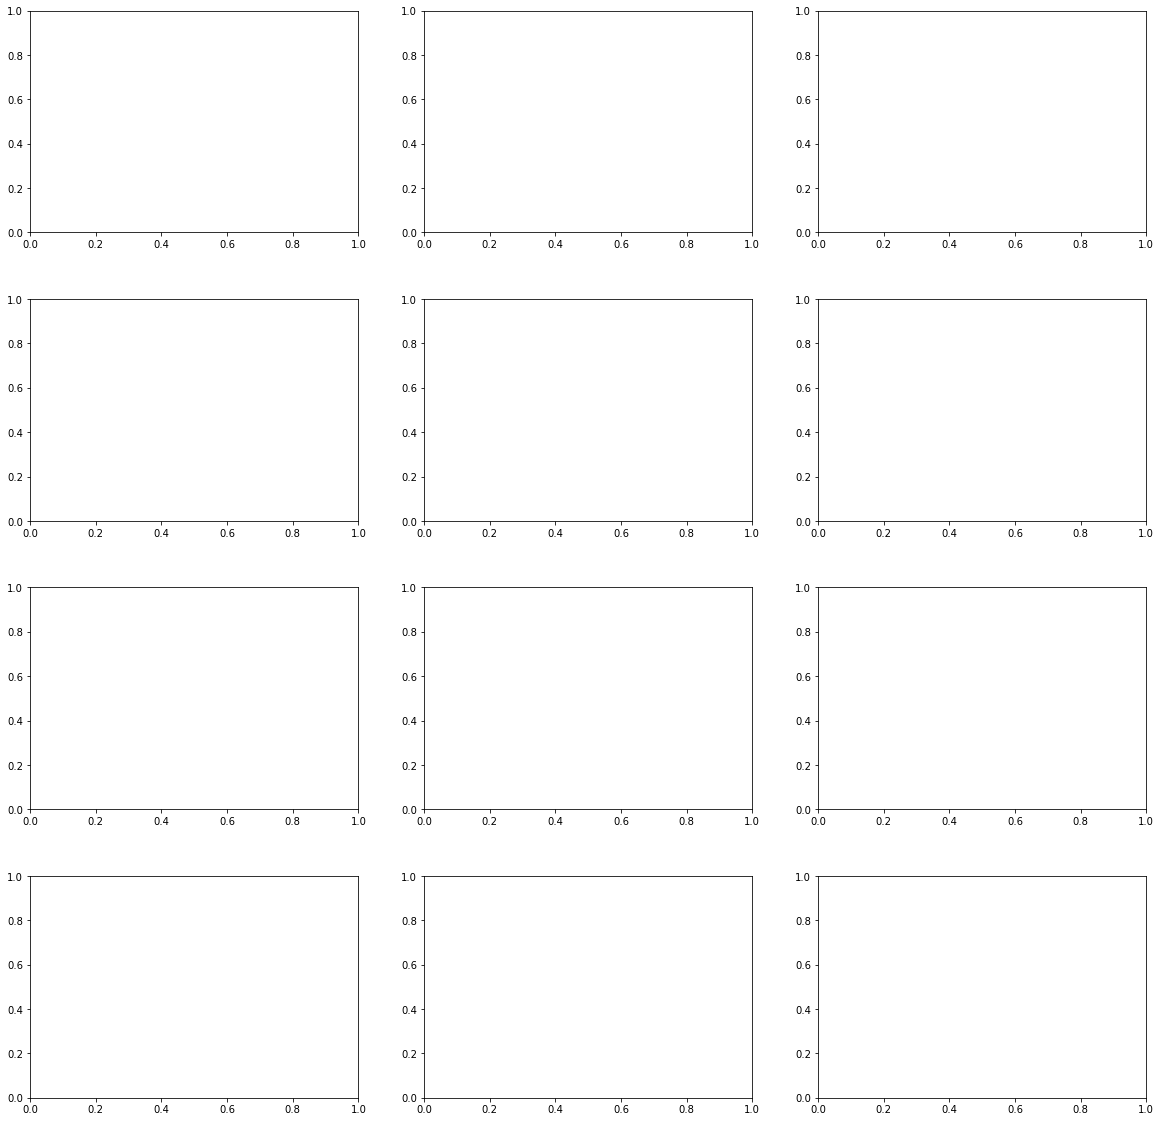

In [228]:
from matplotlib import cm
import math
from itertools import chain
import pylab

def get_df_for_brand(brand):
    return CARS.select('przebieg') \
        .filter(CARS['marka'] == brand)\
        .toPandas()['przebieg']

fig, axes = plt.subplots(math.ceil(len(top_marki) / 3), 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.3)

draws = chain.from_iterable(axes)
datas = map(lambda marka: (marka, get_df_for_brand(marka)), top_marki)
NUM_COLORS = len(top_marki)
cm = pylab.get_cmap('gist_rainbow')
cgen = (cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS))

for marka, data_przebiegi in datas:
    try:
        ax = next(draws)

        ax.hist(data_przebiegi, bins=40, color=next(cgen), edgecolor='k', alpha=0.65)
        xlabels = map(lambda x: "{}k".format(int(x/1000)) ,np.arange(0, 500000, 50000))
        ax.set_xticks(np.arange(0, 500000, 50000))
        ax.set_xticklabels(xlabels)

        av_line = ax.axvline(data_przebiegi.mean(), color='k', linestyle=':', linewidth=1)
        med_line = ax.axvline(data_przebiegi.median(), color='red', linestyle='-.', linewidth=1)
        ax.set_title(marka)
    except StopIteration as e:
        break

while True:
    try:
        ax = next(draws)
        ax.set_visible(False)
    except StopIteration as e:
        break

plt.show()

In [226]:
sc.stop()